In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio

import torch
import torch.nn as nn

import gymnasium as gym
import ale_py

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure

In [2]:
class CustomLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomLoggerCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log custom values here
        self.logger.record("env/reward", self.locals.get("rewards", 0))
        return True

In [3]:
gym.register_envs(ale_py)
env = gym.make("ALE/SpaceInvaders-v5")

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


In [4]:
log_dir = './tensorboard_logs/run2'
logger = configure(log_dir, ['tensorboard'])

In [5]:
model = DQN(policy='CnnPolicy', env=env, buffer_size=10000, verbose=1)
model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [6]:
callback = CustomLoggerCallback()
model.learn(total_timesteps=100000, log_interval=1)

In [7]:
model.save('dqn_spaceinvaders')

In [8]:
del model # remove to demonstrate saving and loading

In [9]:
gym.register_envs(ale_py)
env = gym.make("ALE/SpaceInvaders-v5")

model = DQN.load("dqn_spaceinvaders.zip")

In [10]:
# Video recording function
def record_video_and_plot_rewards(env, model, max_steps=10000, out_directory="./roll_out.mp4", fps=30):
    images = []
    rewards = []
    total_reward = 0

    max_steps = max_steps
    terminated, truncated = False, False
    obs, info = env.reset(seed=random.randint(0, 500))
    images.append(obs)

    while not terminated and not truncated:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Record reward and add to total
        total_reward += reward
        rewards.append(total_reward)

        # Capture frame
        images.append(obs)

        max_steps -= 1
        if max_steps <= 0:
            break

    # Save the video
    imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

    # Plot the reward graph
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Cumulative Reward")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Reward")
    plt.title("Reward Progression During Gameplay")
    plt.legend()
    plt.grid()
    plt.savefig("./reward_graph.png")
    plt.show()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


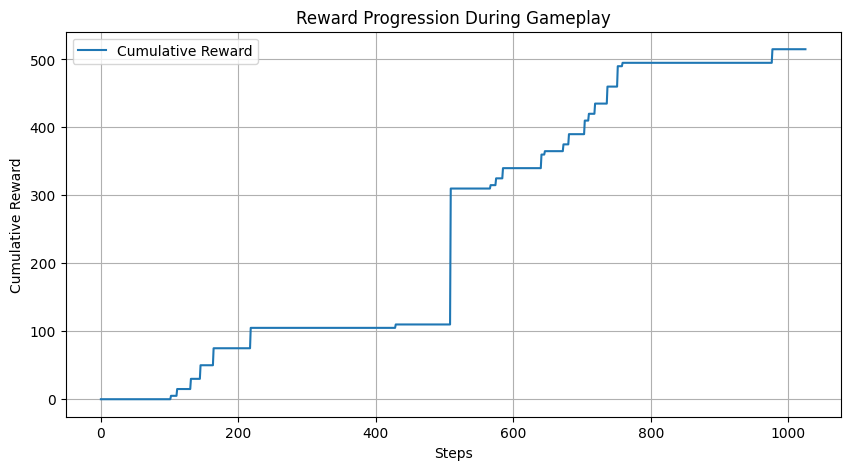

In [11]:
record_video_and_plot_rewards(env=env, model=model)